# Wavelet transformation MNIST

In [2]:
import pywt
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
import timeit
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data load and visualization

Load the MNIST dataset (handwritten digits from 0 to 9). It's separated into train (60000 images) and test (10000 images).

In [3]:
random.seed(666)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


As the images are already in grey scale and all have the same dimensions the only preprocessing we need to do is convert the pixel values to the range [0, 1], normalize.

In [4]:
X_train = x_train / 255.0
X_test = x_test / 255.0

Now we can visualize some of the images.

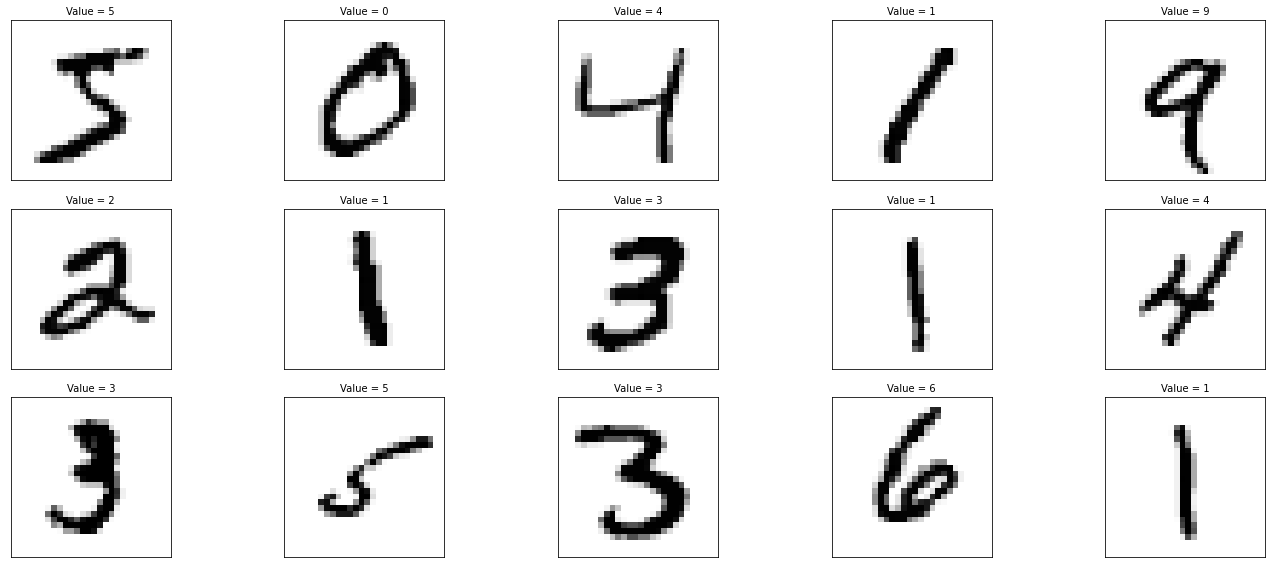

In [5]:
fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(X_train[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Value = ' + str(y_train[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Convolutional neural network with original images

We did the classification with the original images with a convolutional neural network. First we specify that there is only one chanel (grayscale) and convert the real values to vectors with the one hot encoding.

In [6]:
X_train_conv = X_train.reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1], 1)
X_test_conv = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1)

y_train_conv = to_categorical(y_train)
y_test_conv = to_categorical(y_test)

We build a simple model:

In [7]:
model = Sequential()
model.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (X_train_conv[0].shape), padding = 'valid'))
model.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          1

Train the model stopping if it does not improve and save the best.

In [9]:
filepath = 'best_model.hdf5'

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1,  save_best_only = True, mode = 'min')

start = timeit.default_timer()
model_history = model.fit(X_train_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3, callbacks = [earlyStopping, checkpoint])
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 46s 53ms/step - loss: 0.3428 - accuracy: 0.8922 - val_loss: 0.2724 - val_accuracy: 0.9715

Epoch 00001: val_loss improved from inf to 0.27242, saving model to best_model.hdf5
Epoch 2/50
329/329 [==============================] - 16s 50ms/step - loss: 0.0636 - accuracy: 0.9807 - val_loss: 0.0659 - val_accuracy: 0.9806

Epoch 00002: val_loss improved from 0.27242 to 0.06586, saving model to best_model.hdf5
Epoch 3/50
329/329 [==============================] - 17s 51ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0559 - val_accuracy: 0.9834

Epoch 00003: val_loss improved from 0.06586 to 0.05588, saving model to best_model.hdf5
Epoch 4/50
329/329 [==============================] - 17s 51ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 0.0620 - val_accuracy: 0.9823

Epoch 00004: val_loss did not improve from 0.05588
Epoch 5/50
329/329 [==============================] - 17s 51ms/step - loss: 0.0288 - accuracy: 0.9910 - val_l

We can see the train curves.

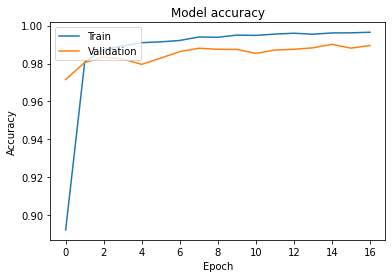

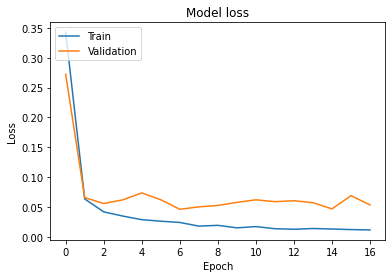

In [10]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

Load the best model and see the accuracy.

In [11]:
model = keras.models.load_model(filepath)

acc = model.evaluate(X_test_conv, y_test_conv)
print(acc[1]*100)

313/313 [==============================] - 2s 7ms/step - loss: 0.0358 - accuracy: 0.9903
99.02999997138977


Get the predictions and plot the confusion matrix.

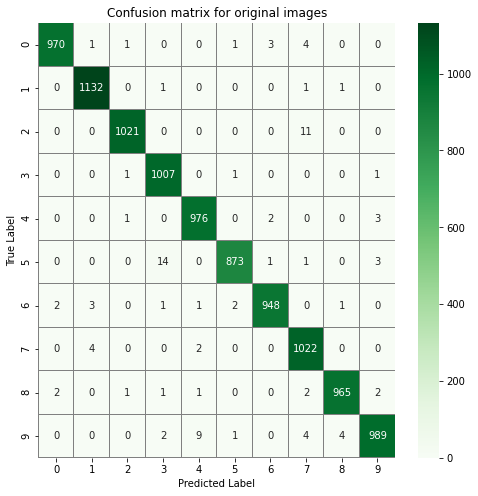

In [12]:
preds = model.predict(X_test_conv)
preds = np.argmax(preds, axis = 1)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for original images")
plt.show()

## Errors

We can visualize some of the errors of the model.

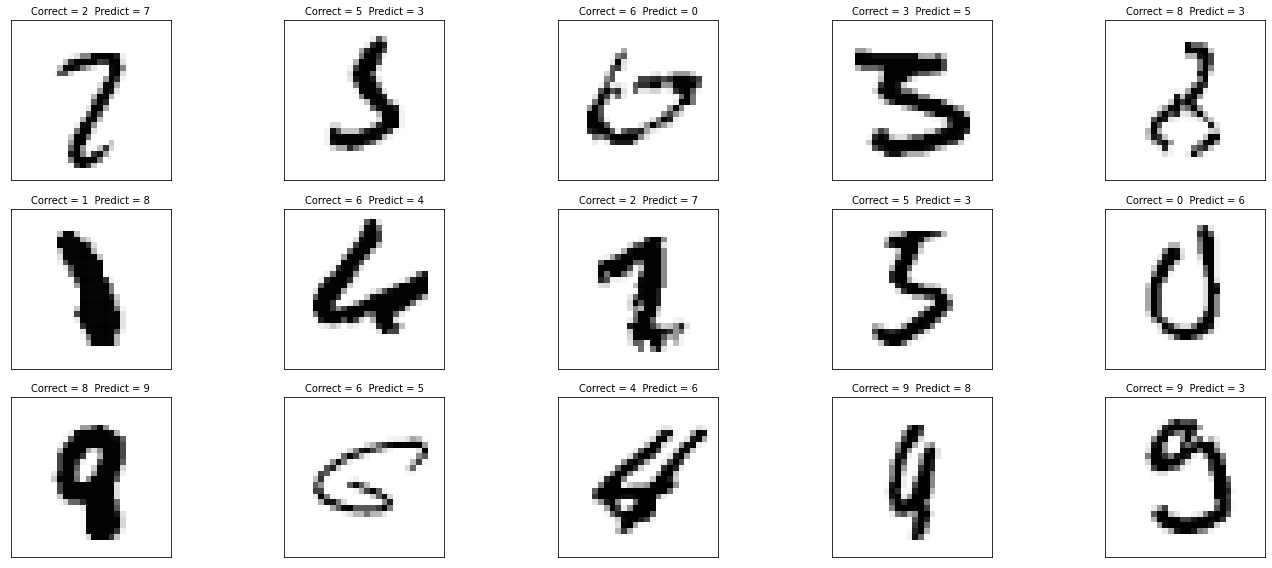

In [13]:
errors = y_test != preds
img_errors= X_test[errors,:]
correct_labels = y_test[errors]
incorrect_labels = preds[errors]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels[i]) + '  Predict = ' + str(incorrect_labels[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Wavelet transform

First we will work with the Haar wavelet. We will do and example for the first image of the dataset and then we will aply the method to all the images. As it is known, in the wavelet tranformation of first order we obtain 4 images (of half size of the original image: 28 x 28 -> 14 x 14): the aproximation image and the horizontal, vertical and diagonal detail images.

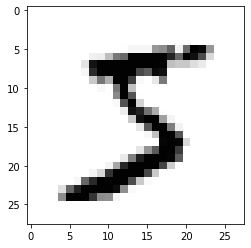

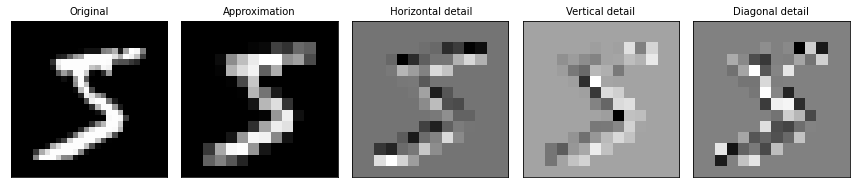

In [20]:
plt.imshow(X_train[0], cmap = "Greys")
plt.show()

titles = ['Original', 'Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(X_train[0], 'haar', 'periodization')
LL0, (LH0, HL0, HH0) = coeffs2

fig = plt.figure(figsize = (12, 3))
for i, a in enumerate([X_train[0], LL0, LH0, HL0, HH0]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(a, interpolation = "nearest", cmap = plt.cm.gray)
    ax.set_title(titles[i], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Now we do it for all the images from test and train.

In [15]:
LL_train = []
LL_test = []

for img in X_train:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_train.append(LLi)
    
for img in X_test:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_test.append(LLi)

## Convolutional neural network with first level wavelet

We train a model but now with the first aproximation images from the wavelet tranformation. As before, first we specify the chanel.

In [21]:
LL_train_conv = np.array(LL_train).reshape(len(LL_train), LL_train[0].shape[0], LL_train[0].shape[1], 1)
LL_test_conv = np.array(LL_test).reshape(len(LL_test), LL_test[0].shape[0], LL_test[0].shape[1], 1)

In [25]:
model_1 = Sequential()
model_1.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (LL_train_conv[0].shape), padding = 'valid'))
model_1.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model_1.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model_1.add(Flatten())
model_1.add(Dense(10, activation = 'relu'))
model_1.add(Dense(100, activation = 'relu'))
model_1.add(Dense(10, activation = 'softmax'))

model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 12, 12, 128)       1280      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 32)         

Train the model.

In [27]:
filepath = 'best_model_wv.hdf5'

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1,  save_best_only = True, mode = 'min')

start = timeit.default_timer()
history_model1 = model_1.fit(LL_train_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3, callbacks = [earlyStopping, checkpoint])
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 6s 17ms/step - loss: 0.3384 - accuracy: 0.8954 - val_loss: 0.2422 - val_accuracy: 0.9713

Epoch 00001: val_loss improved from inf to 0.24217, saving model to best_model_wv.hdf5
Epoch 2/50
329/329 [==============================] - 5s 16ms/step - loss: 0.0684 - accuracy: 0.9796 - val_loss: 0.0683 - val_accuracy: 0.9798

Epoch 00002: val_loss improved from 0.24217 to 0.06826, saving model to best_model_wv.hdf5
Epoch 3/50
329/329 [==============================] - 5s 16ms/step - loss: 0.0448 - accuracy: 0.9868 - val_loss: 0.0549 - val_accuracy: 0.9852

Epoch 00003: val_loss improved from 0.06826 to 0.05486, saving model to best_model_wv.hdf5
Epoch 4/50
329/329 [==============================] - 5s 16ms/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.0743 - val_accuracy: 0.9797

Epoch 00004: val_loss did not improve from 0.05486
Epoch 5/50
329/329 [==============================] - 5s 16ms/step - loss: 0.0329 - accuracy: 0.9904 - v

See the training curves

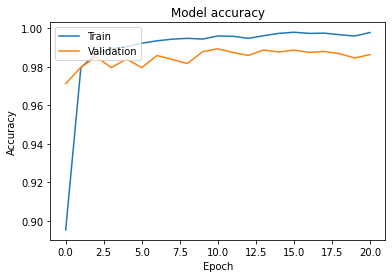

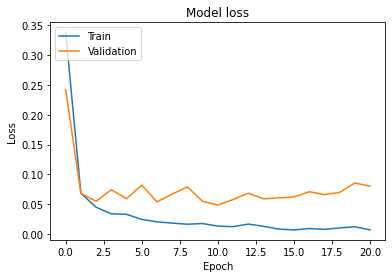

In [28]:
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

See the accuracy of the model.

In [29]:
model_1 = keras.models.load_model(filepath)

acc_LL = model_1.evaluate(LL_test_conv, y_test_conv)
print(acc_LL[1] * 100)

313/313 [==============================] - 2s 4ms/step - loss: 0.0383 - accuracy: 0.9902
99.01999831199646


Get the predictions and plot the confusion matrix.

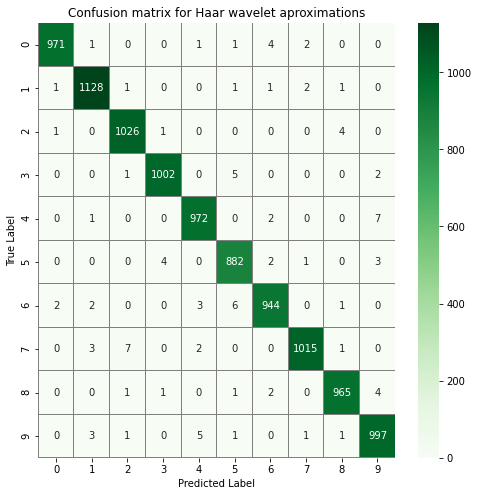

In [30]:
preds_LL = model_1.predict(LL_test_conv)
preds_LL = np.argmax(preds_LL, axis = 1)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds_LL), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for Haar wavelet aproximations")
plt.show()

### Errors

We can visualize again some errors of the model.

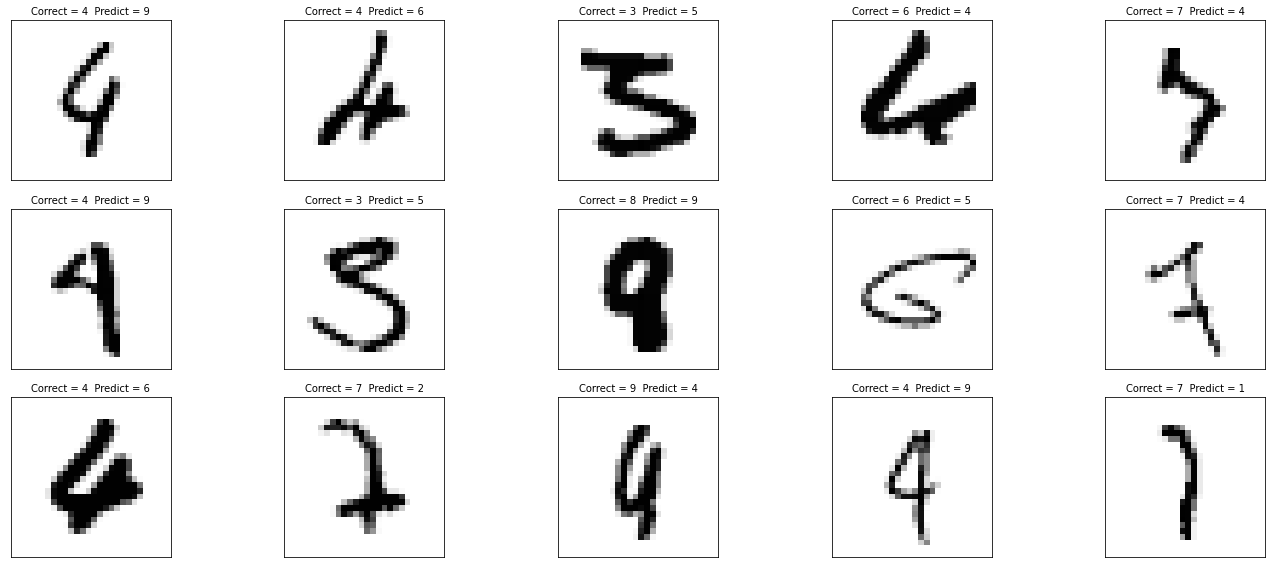

In [31]:
errors_2 = y_test != preds_LL
img_errors_2 = X_test[errors_2,:]
correct_labels_2 = y_test[errors_2]
incorrect_labels_2 = preds_LL[errors_2]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors_2[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels_2[i]) + '  Predict = ' + str(incorrect_labels_2[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Second level wavelet transformation

Let's do again the wavelet tranformation but now over the aproximation images from the first order transformation. First for one image and after that for all of them. Now the images will have a sahpe of 7 x 7.

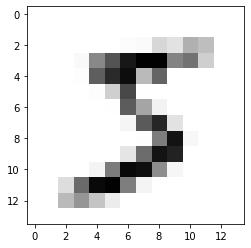

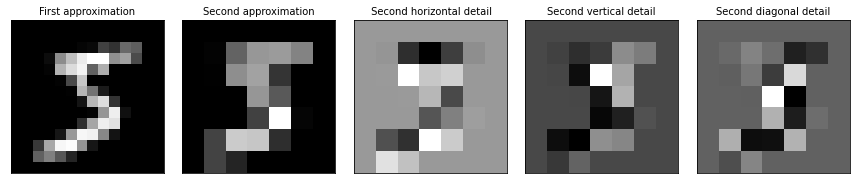

In [32]:
plt.imshow(LL0, cmap = "Greys")
plt.show()

titles = ['First approximation','Second approximation', ' Second horizontal detail', 'Second vertical detail', 'Second diagonal detail']
coeffs2_2 = pywt.dwt2(LL0, 'haar', 'periodization')
LL0_2, (LH0_2, HL0_2, HH0_2) = coeffs2_2

fig = plt.figure(figsize = (12, 3))
for i, a in enumerate([LL0, LL0_2, LH0_2, HL0_2, HH0_2]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(a, interpolation = "nearest", cmap = plt.cm.gray)
    ax.set_title(titles[i], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [33]:
LL_train_2 = []
LL_test_2 = []

for img in LL_train:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_train_2.append(LLi)
    
for img in LL_test:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_test_2.append(LLi)

## Convolutional neural network with second level wavelet

We train a model with the second aproximation images from the second order wavelet tranformation. As before, first we specify the chanel.

In [34]:
LL_train_2_conv = np.array(LL_train_2).reshape(len(LL_train_2), LL_train_2[0].shape[0], LL_train_2[0].shape[1], 1)
LL_test_2_conv = np.array(LL_test_2).reshape(len(LL_test_2), LL_test_2[0].shape[0], LL_test_2[0].shape[1], 1)

In [38]:
model_2 = Sequential()
model_2.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (LL_train_2_conv[0].shape), padding = 'valid'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(100, activation = 'relu'))
model_2.add(Dense(10, activation = 'softmax'))

model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [39]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 5, 5, 128)         1280      
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3, 3, 32)          36896     
_________________________________________________________________
flatten_4 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2890      
_________________________________________________________________
dense_13 (Dense)             (None, 100)              

In [40]:
filepath = 'best_model_wv_2.hdf5'

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min')
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1,  save_best_only = True, mode = 'min')

start = timeit.default_timer()
history_model2 = model_2.fit(LL_train_2_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3, callbacks = [earlyStopping, checkpoint])
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 3s 8ms/step - loss: 0.3903 - accuracy: 0.8753 - val_loss: 0.5160 - val_accuracy: 0.9218

Epoch 00001: val_loss improved from inf to 0.51601, saving model to best_model_wv_2.hdf5
Epoch 2/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1767 - accuracy: 0.9435 - val_loss: 0.1710 - val_accuracy: 0.9457

Epoch 00002: val_loss improved from 0.51601 to 0.17100, saving model to best_model_wv_2.hdf5
Epoch 3/50
329/329 [==============================] - 2s 8ms/step - loss: 0.1459 - accuracy: 0.9533 - val_loss: 0.1445 - val_accuracy: 0.9552

Epoch 00003: val_loss improved from 0.17100 to 0.14453, saving model to best_model_wv_2.hdf5
Epoch 4/50
329/329 [==============================] - 3s 8ms/step - loss: 0.1245 - accuracy: 0.9590 - val_loss: 0.1331 - val_accuracy: 0.9594

Epoch 00004: val_loss improved from 0.14453 to 0.13312, saving model to best_model_wv_2.hdf5
Epoch 5/50
329/329 [==============================] - 3s 8ms

See the training curves

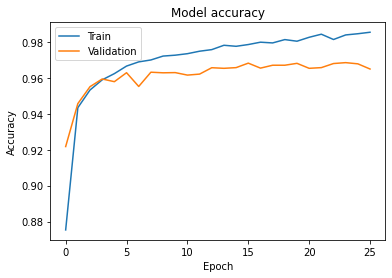

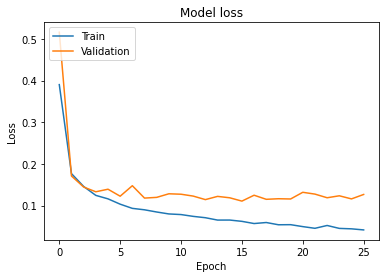

In [41]:
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

See the accuracy of the model.

In [42]:
model_2 = keras.models.load_model(filepath)

acc_LL_2 = model_2.evaluate(LL_test_2_conv, y_test_conv)
print(acc_LL_2[1] * 100)

313/313 [==============================] - 1s 4ms/step - loss: 0.0942 - accuracy: 0.9709
97.08999991416931


Get the predictions and plot the confusion matrix.

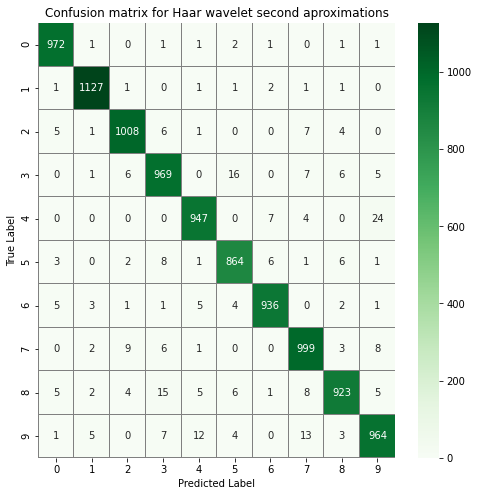

In [43]:
preds_LL_2 = model_2.predict(LL_test_2_conv)
preds_LL_2 = np.argmax(preds_LL_2, axis = 1)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds_LL_2), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for Haar wavelet second aproximations")
plt.show()

### Errors

We can visualize again some errors of the model.

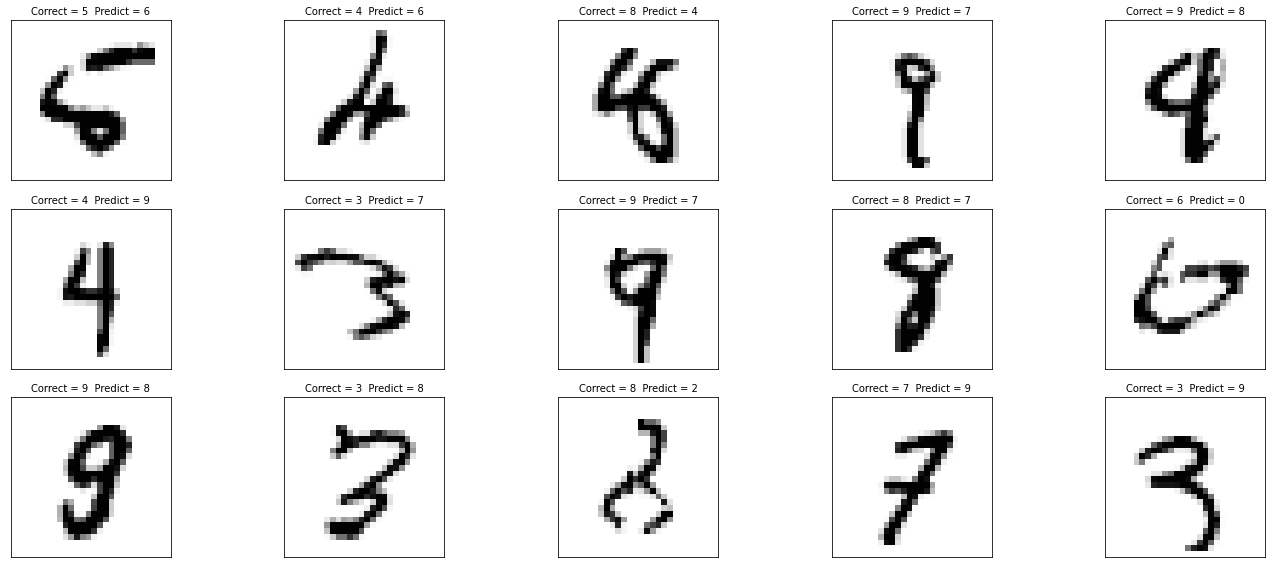

In [44]:
errors_3 = y_test != preds_LL_2
img_errors_3 = X_test[errors_3,:]
correct_labels_3 = y_test[errors_3]
incorrect_labels_3 = preds_LL_2[errors_3]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors_3[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels_3[i]) + '  Predict = ' + str(incorrect_labels_3[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()